# Analysis 1: Fast Food Marketing Campaign A/B Test

Introductory dashboard in Looker Studio is available under the link:\
https://lookerstudio.google.com/embed/reporting/6aaee79f-6692-440d-8b7f-1212fd22b827/page/taaME

## Importing necessary libraries

In [1]:
import pandas as pd
import seaborn as sns
from scipy.stats import chisquare, f_oneway, chi2_contingency, levene
import statsmodels.api as sm
import pylab
import duckdb

## Contex
A fast-food chain plans to add a new item to its menu. However, they are still undecided between three possible marketing campaigns for promoting the new product. In order to determine which promotion has the greatest effect on sales, the new item is introduced at locations in several randomly selected markets. A different promotion is used at each location, and the weekly sales of the new item are recorded for the first four weeks.\
Data source: Kaggle (https://www.kaggle.com/datasets/chebotinaa/fast-food-marketing-campaign-ab-test?resource=download)

## Content
MarketID: unique identifier for market\
MarketSize: size of market area by sales\
LocationID: unique identifier for store location\
AgeOfStore: age of store in years\
Promotion: one of three promotions that were tested\
week: one of four weeks when the promotions were run\
SalesInThousands: sales amount for a specific LocationID, Promotion, and week

## Goal: Evaluating A/B testing results and deciding which marketing campaign bring more sales per market

### Target metric
- **Total Sales per market weekly** was chosen as target metric to measure progress towards the goal

## Dataset overview

Fragment of A/B test results below:

In [36]:
ABtest_campaign_df = pd.read_csv("WA_Marketing-Campaign.csv")
ABtest_campaign_df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


In [ ]:
ABtest_campaign_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MarketID          548 non-null    int64  
 1   MarketSize        548 non-null    object 
 2   LocationID        548 non-null    int64  
 3   AgeOfStore        548 non-null    int64  
 4   Promotion         548 non-null    int64  
 5   week              548 non-null    int64  
 6   SalesInThousands  548 non-null    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 30.1+ KB


- There are no null values in the data
- The most important features for the analysis and target metric belong to SalesInThousands and week columns

### Sample size overview

Because promotion campaign was randomly assigned to market location, number of markets in each promotion group should be equal. Sample size is an important metric which indicates which statistic test to choose and how much power will there be in testing.\
Sample size is also crucial in order to check correct random assignment.

In [4]:
query = """
SELECT Promotion, COUNT(LocationID) market_total
FROM ABtest_campaign_df
GROUP BY 1
"""

Sample_size_df = duckdb.query(query).df()
Sample_size_df

,Promotion,market_total
0,2,188
1,1,172
2,3,188


- The samples sizes vary among the test groups. Further invariant check should be made.

#### Checking Invariants
Assuming that each promotion campaign was randomly assigned to market location, theoretically, number of markets in each promotion group should be equal (Number of markets is an invariant metric)\
How much the number of markets differ between groups?

$H_0$: Number of markets assigned to each promotion campaign IS EQUAL\
$H_a$: Number of markets assigned to each promotion campaign DIFFER\
$\alpha$ = 0.05

In [5]:
chisquare(Sample_size_df.market_total)

Power_divergenceResult(statistic=0.9343065693430658, pvalue=0.6267840066678985)

If the assignment of promotion to a specific market location was truly random, the probability that these group sizes would occur by chance is 0,63 which is more than 0,05. $H_0$ is accepted - there is a no significant difference between group sizes meaning that the promotion type assignment to a specific market location was random.

### Comparing average promotion sales during 4 week period

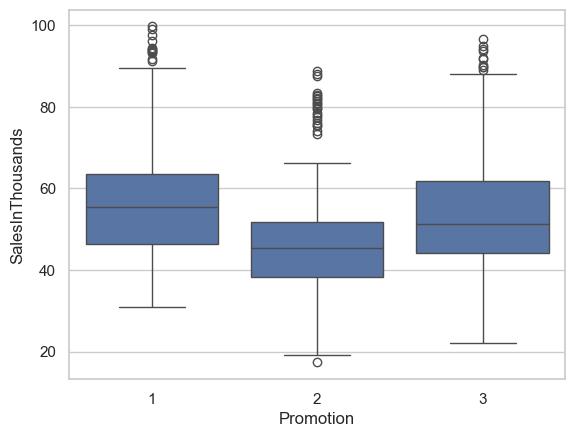

In [6]:
sns.despine(left=True, bottom=True)
sns.set_theme(style="whitegrid")

sns.boxplot(ABtest_campaign_df, x="Promotion", y="SalesInThousands");

- Having only average sales per market from each promotion type does not bring clear conclusion
- Outliers will not be excluded. None of the outliers are more than twice smaller or bigger than the median. There are no suspicions that outliers are untrue or not probable.

### Comparing promotion sales during 4 week period

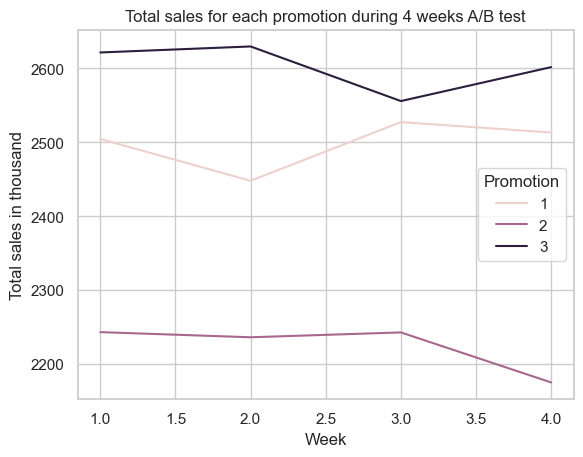

In [7]:
total_sales_plot = sns.lineplot(
    ABtest_campaign_df,
    x=ABtest_campaign_df.week,
    y=ABtest_campaign_df.SalesInThousands,
    hue=ABtest_campaign_df.Promotion,
    errorbar=None,
    estimator="sum",
)
total_sales_plot.set(
    title="Total sales for each promotion during 4 weeks A/B test",
    ylabel="Total sales in thousand",
    xlabel="Week",
);

- Promotion 2 underperforms consistently, suggesting it might be the least effective of the three for driving sales in this period.
- Promotion 1 shows fluctuations but may still be viable as it ends close to Promotion 3’s final sales.
- Promotion 3 appears to be the most effective overall, sustaining higher total sales compared to Promotions 1 and 2.



### Target metric distribution

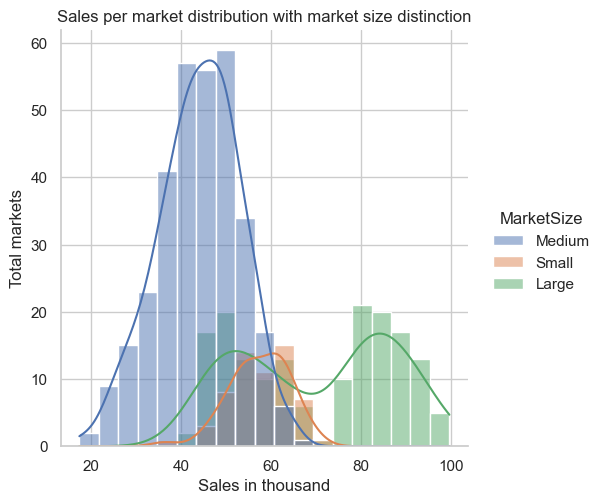

In [8]:
sales_dist_plot = sns.displot(
    ABtest_campaign_df,
    x=ABtest_campaign_df.SalesInThousands,
    hue=ABtest_campaign_df.MarketSize,
    kde=True,
)

sales_dist_plot.set(
    title="Sales per market distribution with market size distinction",
    ylabel="Total markets",
    xlabel="Sales in thousand",
);

- Bimodal distribution of target metric (total sales per market weekly)
- The differing factor lays in **Large markets** group
- Large markets sales can be be subgrouped by unknown factor

## Calculating significant differences on target metric
### One-way ANOVA test
Due to 3 test groups (Promotion 1, 2, 3), in order to check whether there are significant changes in sales between 3 types of promotions, One-way Anova test was applied\
$H_0$: sales in markets with promotion 1, 2 and 3 ARE EQUAL\
$H_a$: sales in markets with promotion 1, 2 and 3 DIFFER\
$\alpha$ = 0.05

Creating Series of Sales for each promotion type for further analysis (values "in Thousands" were transformed into absolute values):

In [9]:
Promotion_1 = ABtest_campaign_df[
    ABtest_campaign_df["Promotion"] == 1
].SalesInThousands.map(lambda x: int(1000 * x))
Promotion_2 = ABtest_campaign_df[
    ABtest_campaign_df["Promotion"] == 2
].SalesInThousands.map(lambda x: int(1000 * x))
Promotion_3 = ABtest_campaign_df[
    ABtest_campaign_df["Promotion"] == 3
].SalesInThousands.map(lambda x: int(1000 * x))

#### Assumptions for ANOVA test:
Before the test, some assumption must be checked:
1. **The data is normally distributed**\
The normal distribution was checked using QQ plot:

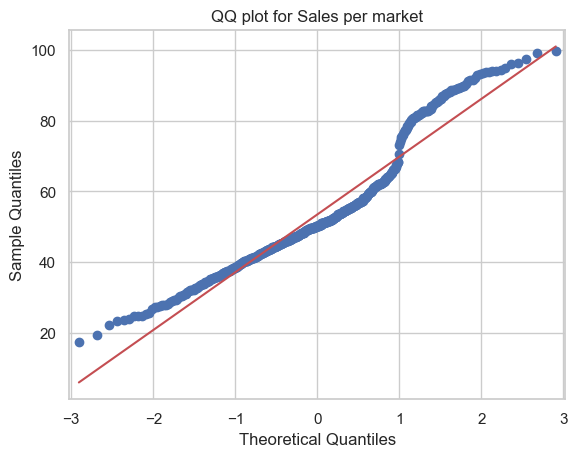

In [10]:
sm.qqplot(ABtest_campaign_df.SalesInThousands, line="r")
pylab.title("QQ plot for Sales per market");

- Target metrics (total sales per market weekly) is not normally distributed among markets
- Based on **Central Limit Theorem** and the fact that sample size >30, we can assume that the sampling distribution is approximately normal.

2. **Variables are independent**\
The variables were collected independently of each other because data come from different market locations.


In [64]:
ABtest_campaign_df['SalesCategory'] = pd.cut(ABtest_campaign_df['LocationID'], bins=5, labels=['v_young', 'young', 'moderate', 'old', 'v_old'])

In [65]:
contingency_table = pd.crosstab(ABtest_campaign_df['Promotion'], ABtest_campaign_df['SalesCategory'])
contingency_table

SalesCategory,v_young,young,moderate,old,v_old
Promotion,,,,,
1,24,44,28,36,40
2,20,40,56,24,48
3,32,40,36,48,32


In [67]:
test_chi2 = chi2_contingency(contingency_table)
test_chi2.pvalue

0.002794393969099982

3. **The variance among the groups is approximately equal**\
The variance differences among the groups can be found using The Levene test which tests the null hypothesis that all input samples are from populations with equal variances. 

In [11]:
levene(Promotion_1, Promotion_2, Promotion_3)

LeveneResult(statistic=1.269686805257621, pvalue=0.28174919829493533)

- Since pvalue > 0.05, we can assume that variances of all 3 populations are approximately equal. 

#### One-way Anova test
After confirmation of assumptions, we can perform the ANOVA test

In [12]:
f_oneway(Promotion_1, Promotion_2, Promotion_3)

F_onewayResult(statistic=21.953445637488546, pvalue=6.766100696713364e-10)

- pvalue <0,05 $H_0$ can be rejected
- There is significant difference in sales of markets with different promotion campaigns
- ANOVA post hoc tests can be applied

### ANOVA post hoc Tukey's HSD test

Since One-way Anova test brought positive result (significant differences), we can apply Post hoc analysis.

In [13]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey_oneway = pairwise_tukeyhsd(
    endog=ABtest_campaign_df["SalesInThousands"],
    groups=ABtest_campaign_df["Promotion"],
    alpha=0.05,
)
tukey_oneway.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
1,2,-10.7696,0.0,-14.7738,-6.7654,True
1,3,-2.7345,0.2444,-6.7388,1.2697,False
2,3,8.0351,0.0,4.1208,11.9493,True


- Estimated difference between the mean sales resulting from Promotion 1 and 2: $10.77 thousands more for Promotion 1 (with 95% confidence that the exact value for this difference is between 6.77 and 14.77 thousand dollars).
- Estimated difference between the mean sales resulting from Promotion 1 and 3: $2.73 thousands (with 95% confidence that the exact value for this difference is between -1.27 and 6.74 thousand dollars).
- Estimated difference between the mean sales resulting from Promotion 2 and 3: $8.04 thousands more for Promotion 3 (with 95% confidence that the exact value for this difference is between 4.12 and 11.95 thousand dollars).

- There is significant difference in mean sales resulting from:
    - Promotion 1 and 2 
    - Promotion 3 and 2 
- There is NO significant difference in mean sales resulting from:
    - Promotion 1 and 3

**Conclusion**: Since we prove that both Promotion 2 and 3 have significant better results than Promotion 2, now we need to choose one promotion and compare Promotion 1 and 3 results. 

### Sales from Promotion 1 vs Promotion 3

#### Confidence Interval of mean difference between Promotion 1 vs 3
Estimating a Difference in Population Means with Confidence (for Sales from Promotion 1 and 3)
Assumptions
- Data are normally distributed
- Samples are considered simple random samples
- Samples are independent from one another


$H_0$: Promotion_1 mean = Promotion_3 mean\
$H_a$: Promotion_1 mean $\neq$  Promotion_3 mean\
$\alpha$ = 0.05


Choosing pooling approach by comparing variance of both populations using the Levene test:

In [14]:
levene(Promotion_1, Promotion_3)

LeveneResult(statistic=3.961867825804408e-05, pvalue=0.9949813847808143)

- Since pvalue > 0.05, we can assume that variances of both populations are approximately equal. 
- Pooled approach chosen.

Setting up variables

In [15]:
N_1 = len(Promotion_1)
N_3 = len(Promotion_3)
diff = Promotion_1.mean() - Promotion_3.mean()
sd_1 = Promotion_1.std()
sd_3 = Promotion_3.std()

Calculating confidence interference
$(\bar{x}_1 - \bar{x}_2) \pm t^* \sqrt{\frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2} \cdot \left( \frac{1}{n_1} + \frac{1}{n_2} \right)}$

In [16]:
margin_error = (
    float(
        (
            ((((N_1 - 1) * sd_1**2) + ((N_3 - 1) * sd_3**2)) / (N_1 + N_3 - 2))
            ** (1 / 2)
        )
        * (((1 / N_1) + (1 / N_3))) ** (1 / 2)
    )
    * 1.98
)

In [17]:
print(f"The mean difference is {round(diff, 2)} +/- {round(margin_error, 2)}")
print(
    f"with 95% confidence that the exact value for this difference between mean sales from promotion\n1 and 3 is between {round(diff-margin_error, 2)} and {round(diff+margin_error, 2)} thousand dollars"
)

The mean difference is 2734.54 +/- 3481.62
with 95% confidence that the exact value for this difference between mean sales from promotion
1 and 3 is between -747.08 and 6216.16 thousand dollars


- There is no significant difference between sales from Promotion 1 and 3. $H_0$ is accepted 

### Sales from Promotion 1 vs Promotion 3 (Bootstrap simulation)
$H_0$: Promotion_1 - Promotion_3 mean sales in week X = 0\
$H_a$: Promotion_1 - Promotion_3 mean sales in week X $\neq$ 0\
$\alpha$ = 0.05\
N = 10000

For each week:
1. Randomly sample with replacement from each group separately. The size of samples is equal to the size of the original group.
2. Calculate the difference of means between two created samples.
3. Repeat steps 1-2 n times. (We will choose n as num_samples = 10000).
4. Count p-value, as a proportion of bootstrap samples where the absolute value of mean difference is greater than or equal to the absolute value of the observed mean difference.

In [18]:
def bootstrap(week, num_samples, alpha):

    count = 0
    diffs = []

    P1 = ABtest_campaign_df[
        (ABtest_campaign_df["Promotion"] == 1)
        & (ABtest_campaign_df["week"] == week)
    ].SalesInThousands.map(lambda x: int(1000 * x))
    P3 = ABtest_campaign_df[
        (ABtest_campaign_df["Promotion"] == 3)
        & (ABtest_campaign_df["week"] == week)
    ].SalesInThousands.map(lambda x: int(1000 * x))

    difference_1vs3 = P1.mean() - P3.mean()
    print(f"Difference of mean values {difference_1vs3:.2f}")

    for i in range(num_samples):
        subsample_1 = P1.sample(n=len(P1), replace=True)
        subsample_3 = P3.sample(n=len(P3), replace=True)

        # calculate difference of means of 2 subsamples
        bootstrap_difference = subsample_1.mean() - subsample_3.mean()
        diffs.append(bootstrap_difference)

    for el in diffs:
        if abs(el) >= abs(difference_1vs3):
            count += 1

    pvalue = count / num_samples
    print("p-value =", pvalue)

    if pvalue < alpha:
        print("Reject H0: mean values do differ significantly")
    else:
        print("Accept H0: mean values do not differ significantly")
    bootstrap_plot = sns.displot(diffs)
    bootstrap_plot.set(
        title=f"Bootstrap simulation.\n Differences of mean values between Promotion 1 and 3 in week {week}",
        ylabel="Count",
        xlabel="simulated mean difference",
    )

#### Week 1

Difference of mean values 2468.25
p-value = 0.5859
Accept H0: mean values do not differ significantly


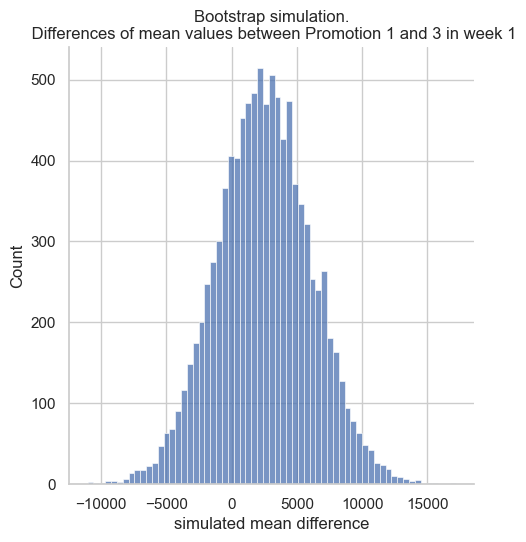

In [19]:
bootstrap(1, 10000, 0.5)

#### Week 2

Difference of mean values 980.39
p-value = 0.7855
Accept H0: mean values do not differ significantly


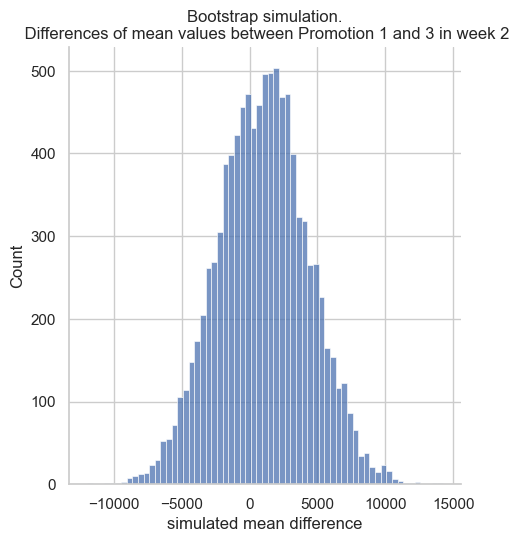

In [20]:
bootstrap(2, 10000, 0.5)

#### Week 3

Difference of mean values 4397.01
p-value = 0.514
Accept H0: mean values do not differ significantly


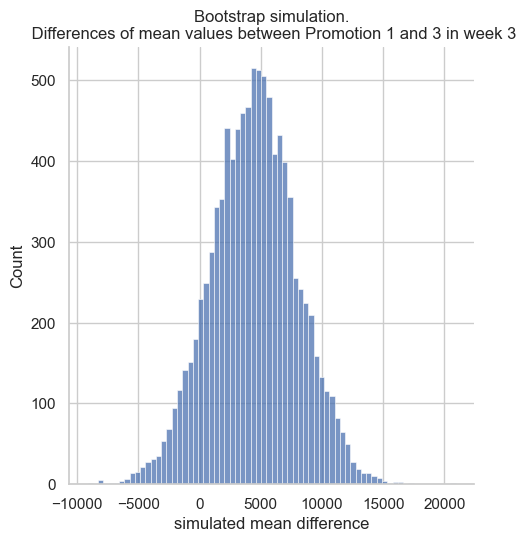

In [21]:
bootstrap(3, 10000, 0.5)

#### Week 4

Difference of mean values 3092.53
p-value = 0.5425
Accept H0: mean values do not differ significantly


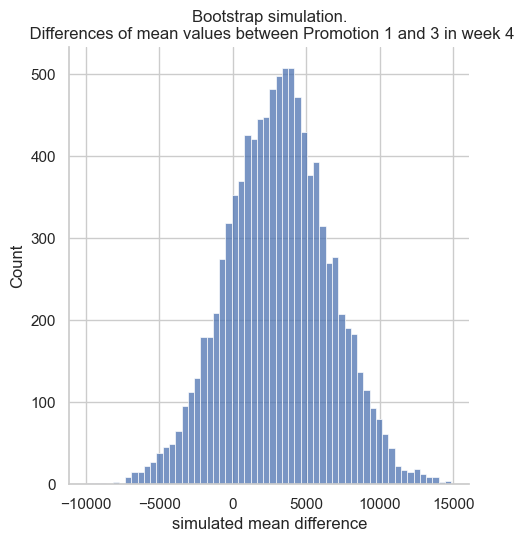

In [22]:
bootstrap(4, 10000, 0.5)

- $H_0$ for all time points can be accepted

**Final Conclusions**
1. Promotion 2 performed significantly worse than both Promotions 1 and 3.
2. Choosing between Promotion 1 and 3: Neither total sales from Promotions 1 and 3 nor weekly sales from these promotions showed a significant difference between the two types. There is no clear advantage in choosing one promotion type over the other.\
Other factors, such as public relations impact and implementation costs, should also be considered in decision-making.
3. Further analysis of other metrics should be performed in order to find differing factor which induce bimodal distribution